In [1]:
import os
import shutil

# Remover o diretório __pycache__ se existir
if os.path.exists('__pycache__'):
    shutil.rmtree('__pycache__')

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D, Conv1D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, recall_score, precision_score, precision_recall_curve, roc_curve, classification_report, auc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import sys
sys.path.append('/eos/home-i03/m/mdemelop/SWAN_projects/ML/Seminario')

import os
from particle_types import ParticleType
from jet_labels import create_labels_single_column, ParticleType
from models import model_efp, build_model_a, build_model_b, build_model_a_wBN
from sklearn.utils import shuffle
from utilities import save_model
from data_loaders import  load_data_qg_tagging,  load_data_qg_tagging_wR

2024-06-22 18:40:42.900041: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 18:40:42.988412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
root_data_folder = '/eos/home-i03/m/mdemelop/SWAN_projects/ML/Seminario/Data/'

In [15]:
# Calculating X_train, y_train, X_val, y_val, X_test and y_test 
# Loads the data for the QuarkGluon-tagging and shuffle by load_data_top_tagging


# Without mean DeltaRij as add feature 
# X_train, y_train = load_data_qg_tagging(
#     quark_data_path=f"{root_data_folder}/Trainning/q_jets_efps_d5_primed.npy", 
#     gluon_data_path=f"{root_data_folder}/Trainning/g_jets_efps_d5_primed.npy")

# X_val, y_val = load_data_qg_tagging(
#     quark_data_path=f"{root_data_folder}/Validation/q_jets_efps_d5_primed.npy", 
#     gluon_data_path=f"{root_data_folder}/Validation/g_jets_efps_d5_primed.npy")


# X_test, y_test = load_data_qg_tagging(
#     quark_data_path=f"{root_data_folder}/Test/q_jets_efps_d5_primed.npy", 
#     gluon_data_path=f"{root_data_folder}/Test/g_jets_efps_d5_primed.npy")



# With mean DeltaRij as add feature

print("Loading trainning data...")
X_train, y_train = load_data_qg_tagging_wR(
    quark_data_path=f"{root_data_folder}/Trainning/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"{root_data_folder}/Trainning/g_jets_efps_d5_primed.npy",
    mean_deltaRij_quark_path=f"{root_data_folder}/Trainning/mean_deltaRij_q.npy",
    mean_deltaRij_gluon_path=f"{root_data_folder}/Trainning/mean_deltaRij_g.npy")

print("Loading validation data...")
X_val, y_val = load_data_qg_tagging_wR(
    quark_data_path=f"{root_data_folder}/Validation/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"{root_data_folder}/Validation/g_jets_efps_d5_primed.npy",
    mean_deltaRij_quark_path=f"{root_data_folder}/Validation/mean_deltaRij_q.npy",
    mean_deltaRij_gluon_path=f"{root_data_folder}/Validation/mean_deltaRij_g.npy")

print("Loading testing data...")
X_test, y_test = load_data_qg_tagging_wR(
    quark_data_path=f"{root_data_folder}/Test/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"{root_data_folder}/Test/g_jets_efps_d5_primed.npy",
    mean_deltaRij_quark_path=f"{root_data_folder}/Test/mean_deltaRij_q.npy",
    mean_deltaRij_gluon_path=f"{root_data_folder}/Test/mean_deltaRij_g.npy")




print('Ok')

Loading trainning data...
Loading validation data...
Loading testing data...
Ok


In [16]:
# Normalize the data (example using StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Expand the dimension of inputs to the format expected by Conv1D model
X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)
X_val_scaled = np.expand_dims(X_val_scaled, axis=-1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)



# train -> used for training the model
# val -> used for validation, tuning hyperparameters, and evaluating model performance during training
# test -> test set, used for evaluating the final model performance

# Checking sizes of the datasets
print(f'Training set size: {X_train_scaled.shape[0]}')
print(f'Validation set size: {X_val_scaled.shape[0]}')
print(f'Test set size: {X_test_scaled.shape[0]}')
print(f'X_train.shape[1]:', X_train_scaled.shape[1])

Training set size: 251379
Validation set size: 44362
Test set size: 52190
X_train.shape[1]: 55


In [23]:
# Build and compile the model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model_a = build_model_a(input_shape)

#binary_crossentropy for model a 
#categorical_crossentropy for model b 
model_a.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_a.fit(
    X_train_scaled, y_train,
    epochs=100,  # Definir o número total de épocas desejadas
    batch_size=50,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy, test_auc = model_a.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test AUC: {test_auc:.4f}')

# Save the model 
save_model(model_a, history, 'qg_model_a_wR')

Epoch 1/100
5028/5028 [==============================] - 53s 10ms/step - loss: 0.6320 - accuracy: 0.6206 - auc_3: 0.6808 - val_loss: 0.4816 - val_accuracy: 0.7694 - val_auc_3: 0.8525
Epoch 2/100
5028/5028 [==============================] - 50s 10ms/step - loss: 0.4397 - accuracy: 0.7997 - auc_3: 0.8774 - val_loss: 0.4399 - val_accuracy: 0.8021 - val_auc_3: 0.8830
Epoch 3/100
5028/5028 [==============================] - 48s 10ms/step - loss: 0.4277 - accuracy: 0.8063 - auc_3: 0.8845 - val_loss: 0.4262 - val_accuracy: 0.8063 - val_auc_3: 0.8861
Epoch 4/100
5028/5028 [==============================] - 49s 10ms/step - loss: 0.4239 - accuracy: 0.8083 - auc_3: 0.8867 - val_loss: 0.4227 - val_accuracy: 0.8091 - val_auc_3: 0.8881
Epoch 5/100
5028/5028 [==============================] - 49s 10ms/step - loss: 0.4221 - accuracy: 0.8091 - auc_3: 0.8876 - val_loss: 0.4255 - val_accuracy: 0.8082 - val_auc_3: 0.8872
Epoch 6/100
5028/5028 [==============================] - 48s 10ms/step - loss: 0.4206

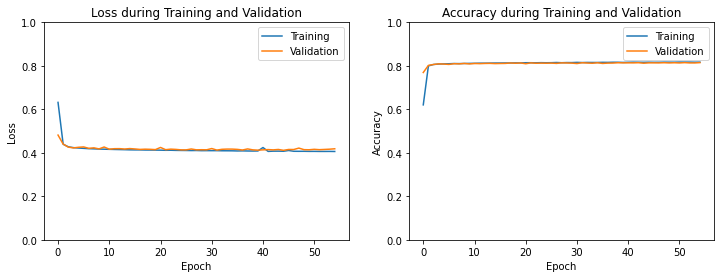

In [24]:
# Plotting loss during training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0., 1.)
plt.legend()

# Plotting accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0., 1.)
plt.legend()

plt.show()

In [25]:
# Classification report on the test set
y_pred = (model_a_wBN.predict(X_test_scaled) > 0.5).astype("int32")
print("Classification Report - Test Set")
print(classification_report(y_test, y_pred, target_names=['Quark', 'Gluon']))

1631/1631 [==============================] - 4s 3ms/step
Classification Report - Test Set
              precision    recall  f1-score   support

       Quark       0.80      0.84      0.82     26588
       Gluon       0.82      0.78      0.80     25602

    accuracy                           0.81     52190
   macro avg       0.81      0.81      0.81     52190
weighted avg       0.81      0.81      0.81     52190



In [26]:
# Classification report on the test set
y_pred = (model_a_wBN.predict(X_train_scaled) > 0.5).astype("int32")
print("Classification Report - Train Set")
print(classification_report(y_train, y_pred, target_names=['Quark', 'Gluon']))

7856/7856 [==============================] - 20s 3ms/step
Classification Report - Train Set
              precision    recall  f1-score   support

       Quark       0.80      0.84      0.82    128064
       Gluon       0.83      0.78      0.80    123315

    accuracy                           0.81    251379
   macro avg       0.81      0.81      0.81    251379
weighted avg       0.81      0.81      0.81    251379



1631/1631 [==============================] - 4s 3ms/step


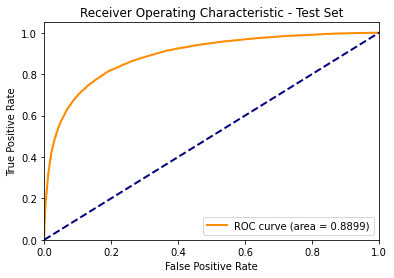

In [27]:
# Predicted probabilities on the test set
y_pred_prob_test = model_a_wBN.predict(X_test_scaled).ravel()

# ROC curve and AUC on the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting ROC curve for the test set
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Predicted probabilities on the validation set
y_pred_prob_vl = model_a_wBN.predict(X_test_scaled).ravel()

# ROC curve and AUC on the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting ROC curve for the test set
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc='lower right')
plt.show()

7856/7856 [==============================] - 20s 3ms/step


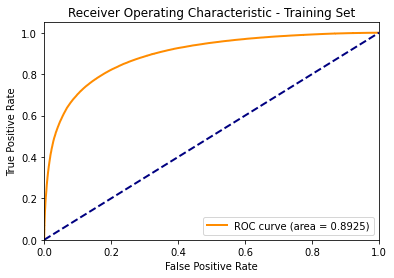

In [28]:
# Predicted probabilities on the training set
y_pred_prob_train = model_a_wBN.predict(X_train_scaled).ravel()

# ROC curve and AUC on the training set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Plotting ROC curve for the training set
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_train:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Training Set')
plt.legend(loc='lower right')
plt.show()